# CS108/212 STAT108/212 W25 Course Project

### Team Details

- Teammate 1: Stella Park
- Teammate 2: Alex Back
- Teammate 3: Thien Pham
- Teammate 4: Arjun Khanna

---


# Milestone: Mitigating Bias
For this project milestone, each teammate will implement bias mitigation strategies and assess pre and post bias mitigation performance.

# Installs

In [3]:
# [INSERT CODE HERE to install necessary packages

# Uncomment to Download
!pip install aif360
!pip install 'aif360[Reductions]'
!pip install 'aif360[inFairness]'
!pip install fairlearn
!pip install BlackBoxAuditing

ERROR: Invalid requirement: "'aif360[Reductions]'": Expected package name at the start of dependency specifier
    'aif360[Reductions]'
    ^
ERROR: Invalid requirement: "'aif360[inFairness]'": Expected package name at the start of dependency specifier
    'aif360[inFairness]'
    ^


# Imports

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import collections
from sklearn.model_selection import train_test_split
import pprint

# added
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from aif360.metrics import ClassificationMetric
from aif360.datasets import BinaryLabelDataset
from sklearn.linear_model import LogisticRegression
from aif360.algorithms.postprocessing import EqOddsPostprocessing
from sklearn.ensemble import RandomForestClassifier
from aif360.algorithms.inprocessing import PrejudiceRemover
from aif360.algorithms.preprocessing import DisparateImpactRemover

pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[inFairness]'


# Loading dataset
_(same as previous milestone, copy-paste)_

In [7]:
# Load your selected dataset
# Loading dataset
df = pd.read_csv("compas-scores-two-years.csv")

# Check if dataset is successfully loaded
df.head()

X = df[['age', 'priors_count', 'decile_score']] # features
y = df['two_year_recid']  # target
sensitive_feature_colname = 'race' # sensitive feature name

# Make sensitive features-based group labels
group_labels = df[sensitive_feature_colname]

# Print some stats
print(f"No. of samples: {X.shape[0]}")
print(f"No. of features: {X.shape[1]}")
print(f"Group Counts: {dict(collections.Counter(group_labels))}")

No. of samples: 7214
No. of features: 3
Group Counts: {'Other': 377, 'African-American': 3696, 'Caucasian': 2454, 'Hispanic': 637, 'Native American': 18, 'Asian': 32}


# Preparing dataset
_(same as previous milestone, copy-paste)_

In [9]:
# ----------- Step 1: Drop unnecessary columns ----------
unnecessary_cols = [
    'first', 'last', 'id', 'dob', 'compas_screening_date', 'c_case_number', 
    'c_offense_date', 'c_arrest_date', 'r_case_number', 'r_offense_date', 
    'r_charge_desc', 'r_jail_in', 'r_jail_out', 'vr_case_number', 
    'vr_offense_date', 'vr_charge_desc', 'v_screening_date', 'violent_recid'
]

# Drop unnecessary columns
df_cleaned = df.drop(columns=[col for col in unnecessary_cols if col in df.columns], errors='ignore')

print(f"Remaining columns after dropping unnecessary features: {df_cleaned.columns.tolist()}")

# ----------- Step 2: Handle missing data -------------
# Check and handle missing values
missing_counts = df_cleaned.isnull().sum()
print("Missing values before handling:\n", missing_counts[missing_counts > 0])

df_cleaned = df_cleaned.dropna(axis=1, how='all')  # Drop columns with all missing values

# Fill missing numeric data with median and categorical with mode
numeric_cols = df_cleaned.select_dtypes(include=['number']).columns.tolist()
categorical_cols = df_cleaned.select_dtypes(include=['object']).columns.tolist()

df_cleaned[numeric_cols] = df_cleaned[numeric_cols].apply(lambda x: x.fillna(x.median()))
df_cleaned[categorical_cols] = df_cleaned[categorical_cols].apply(lambda x: x.fillna(x.mode()[0]))

print(f"Remaining missing values after handling: {df_cleaned.isnull().sum().sum()} (should be 0)")

# ----------- Step 3: Encode categorical features ----------
# One-hot encode selected categorical features
categorical_cols = ['sex', 'race', 'c_charge_degree']
df_encoded = pd.get_dummies(df_cleaned, columns=categorical_cols, drop_first=True)

print(f"Remaining features after encoding: {df_encoded.shape[1]}")

# ---------- Step 4: Normalize numerical features ---------
# Normalize selected numerical features
numerical_cols = ['age', 'priors_count', 'decile_score']
scaler = StandardScaler()
df_encoded[numerical_cols] = scaler.fit_transform(df_encoded[numerical_cols])

print("Numerical features normalized.")

# ---------- Step 5: Encode Target ---------------
# Convert target to integer
df_encoded['two_year_recid'] = df_encoded['two_year_recid'].astype(int)

# Separate features and target
X = df_encoded.drop(columns=['two_year_recid'])
y = df_encoded['two_year_recid']

print("Encoded dataset columns:", X.columns.tolist())

# Identify race group labels dynamically (assuming 'race_African-American' is missing)
race_columns = ['race_Asian', 'race_Caucasian', 'race_Hispanic', 'race_Native American', 'race_Other']
group_labels = (X[race_columns].sum(axis=1) == 0).astype(int)  # 1 = African-American, 0 = Other

print(f"Group labels assigned: {group_labels.value_counts().to_dict()}")

# Final checks
print(f"No. of samples AFTER cleaning: {X.shape[0]}")
assert X.shape[0] == y.shape[0] == group_labels.shape[0], "Dataset sizes do not match!"
print(f"No. of features AFTER encoding: {X.shape[1]}")

Remaining columns after dropping unnecessary features: ['name', 'sex', 'age', 'age_cat', 'race', 'juv_fel_count', 'decile_score', 'juv_misd_count', 'juv_other_count', 'priors_count', 'days_b_screening_arrest', 'c_jail_in', 'c_jail_out', 'c_days_from_compas', 'c_charge_degree', 'c_charge_desc', 'is_recid', 'r_charge_degree', 'r_days_from_arrest', 'is_violent_recid', 'vr_charge_degree', 'type_of_assessment', 'decile_score.1', 'score_text', 'screening_date', 'v_type_of_assessment', 'v_decile_score', 'v_score_text', 'in_custody', 'out_custody', 'priors_count.1', 'start', 'end', 'event', 'two_year_recid']
Missing values before handling:
 days_b_screening_arrest     307
c_jail_in                   307
c_jail_out                  307
c_days_from_compas           22
c_charge_desc                29
r_charge_degree            3743
r_days_from_arrest         4898
vr_charge_degree           6395
in_custody                  236
out_custody                 236
dtype: int64
Remaining missing values a

# Getting training and testing sets

Note: Train-test split is made **ONCE** to obtain the _training set_ and the _testing set_ and every teammate will use the training set to train their baseline model and test the trained model using the testing set. **NEVER** modify the testing set once it has been created.
Therefore, the following code cell does not need to be edited.

_(same as previous milestone, copy-paste)_

In [11]:
X_train, X_test, \
  y_train, y_test, \
    group_labels_train, group_labels_test = train_test_split(X, y, group_labels, test_size=0.2, random_state=42)

print(f"No. of training samples: {X_train.shape[0]}")
print(f"No. of testing samples: {X_test.shape[0]}")

assert X_train.shape[0] == y_train.shape[0] == group_labels_train.shape[0], "Mismatch in training set sizes!"
assert X_test.shape[0] == y_test.shape[0] == group_labels_test.shape[0], "Mismatch in testing set sizes!"

# Delete X, y and group_label variables to make sure they are not used later on.
del X
del y
del group_labels

No. of training samples: 5771
No. of testing samples: 1443


# Setting up evaluation metrics
Note: The same evaluation function will be used by all teammates.

_(same as previous milestone, copy-paste)_

In [13]:
def evaluate_model(y_test, y_pred, group_labels):
    """Evaluate model performance and fairness."""

    # Ensure y_test and group_labels are numpy arrays
    y_test = np.array(y_test)
    group_labels = np.array(group_labels)

    # Performance metrics
    results = {
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred),
        "recall": recall_score(y_test, y_pred),
        "f1_score": f1_score(y_test, y_pred)
    }

    # Convert test and predicted data to AIF360 format
    test_data = BinaryLabelDataset(df=pd.DataFrame({"y_test": y_test, "group": group_labels}),
                                   label_names=["y_test"],
                                   protected_attribute_names=["group"])
    
    pred_data = test_data.copy()
    pred_data.labels = np.array(y_pred).reshape(-1, 1)

    # Compute fairness metrics
    metric = ClassificationMetric(test_data, pred_data,
                                  privileged_groups=[{"group": 0}],  # Example: privileged group
                                  unprivileged_groups=[{"group": 1}])  # Example: unprivileged group

    results["demographic_parity"] = metric.disparate_impact()
    results["equalized_odds"] = metric.equal_opportunity_difference()

    # Print results
    print("\n--- Model Evaluation ---")
    for key, value in results.items():
        print(f"{key.capitalize()}: {value:.4f}")

    return results

# Training baseline models (INDIVIDUAL CONTRIBUTION)
_(minor modifications from previous milestone)_

In [15]:
## A place to save all teammates's baseline results
all_baseline_results = [] ## DO NOT EDIT

## Teammate 1

In [17]:
# *** Noticed that baseline model is 99%, and when I did Equalized odds post processing, it did not improve, 
# *** Tried different method, and it gave 100% accuracy which was very odd, so tried to find leaks and remove, 
# *** and it does lower the accuracy in both premitigation and post mitigation. unsure if it should be done or not so 
# *** left it as comment for now.

# Check correlations
# correlations = np.corrcoef(X_test.select_dtypes(include=['number']).values.T, y_test.values)[-1, :-1]
# print("\nFeature correlations:", correlations)

# Find leaks
# leaked_features = [col for col, corr in zip(X_test.select_dtypes(include=['number']).columns, correlations) if abs(corr) > 0.8]

# print("\nLeaked features:", leaked_features)

# Remove leaks
# X_train.drop(columns=leaked_features, errors='ignore', inplace=True)
# X_test.drop(columns=leaked_features, errors='ignore', inplace=True)

# =====================================
# Train Baseline Model (Pre-Mitigation)
# =====================================

# Select only numeric features
X_train = X_train.select_dtypes(include=['number'])
X_test = X_test.select_dtypes(include=['number'])

# Scale features
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

print("Data scaling completed")

# Train Logistic Regression model
log_reg = LogisticRegression(max_iter=500)
log_reg.fit(X_train_scaled, y_train)

print("Model training completed")

# Predictions (Baseline)
y_pred = log_reg.predict(X_test_scaled)
print("Predictions generated successfully")

# Evaluate model (Baseline)
results = evaluate_model(y_test, y_pred, group_labels_test)

results['teammate'] = 'Teammate 1'
results['experiment_type'] = 'baseline'
results['predictor_model'] = "Logistic Regression (Scaled)"
# Pre-mitigation baseline
results['mitigation_strategy'] = 'NONE'

all_baseline_results.append(results)

# display
print("Baseline Model Results:")
pprint.pprint(results)

Data scaling completed
Model training completed
Predictions generated successfully

--- Model Evaluation ---
Accuracy: 0.9903
Precision: 0.9810
Recall: 0.9968
F1_score: 0.9888
Demographic_parity: 1.4418
Equalized_odds: 0.0013
Baseline Model Results:
{'accuracy': 0.9902979902979903,
 'demographic_parity': 1.4418389219815375,
 'equalized_odds': 0.0013440860215053752,
 'experiment_type': 'baseline',
 'f1_score': 0.9888,
 'mitigation_strategy': 'NONE',
 'precision': 0.9809523809523809,
 'predictor_model': 'Logistic Regression (Scaled)',
 'recall': 0.9967741935483871,
 'teammate': 'Teammate 1'}


## Teammate 2: Alex Back

In [19]:
# Select a model and train it on the training set
non_numeric_cols = X_train.select_dtypes(include=['object']).columns

X_train = X_train.drop(columns=non_numeric_cols)
X_test = X_test.drop(columns=non_numeric_cols)

rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions on the testing set and store them in y_pred
y_pred = rf_model.predict(X_test)

# Evaluate testing set predictions using evaluate_model()
results = evaluate_model(y_test, y_pred, group_labels_test)

# Save your results to all_baseline_results
results['teammate'] = 'Teammate 2'
results['experiment_type'] = 'baseline'
results['predictor_model'] = 'RandomForestClassifier'
results['mitigation_strategy'] = 'NONE' ## DO NOT EDIT: This is pre-mitigation baseline
all_baseline_results.append(results)

pprint.pprint(results)


--- Model Evaluation ---
Accuracy: 0.9917
Precision: 0.9825
Recall: 0.9984
F1_score: 0.9904
Demographic_parity: 1.4610
Equalized_odds: -0.0027
{'accuracy': 0.9916839916839917,
 'demographic_parity': 1.4610123119015048,
 'equalized_odds': -0.0026881720430107503,
 'experiment_type': 'baseline',
 'f1_score': 0.9904,
 'mitigation_strategy': 'NONE',
 'precision': 0.9825396825396825,
 'predictor_model': 'RandomForestClassifier',
 'recall': 0.9983870967741936,
 'teammate': 'Teammate 2'}


## Teammate 3

In [21]:
# Select a model and train it on the training set
# Train Log reg model
# Select only numeric features
X_train = X_train.select_dtypes(include=['number'])
X_test = X_test.select_dtypes(include=['number'])
lreg_unscaled = LogisticRegression()
lreg_unscaled.fit(X_train, y_train)
# Make predictions on the testing set and store them in y_pred
y_pred = lreg_unscaled.predict(X_test)

# Evaluate testing set predictions using evaluate_model()
results = evaluate_model(y_test, y_pred, group_labels_test)
print("Unscaled Logistic Reg. Model Results:")
print(results)


# Save your results to all_baseline_results
results['teammate'] = 'Teammate 3'
results['experiment_type'] = 'baseline'
results['predictor_model'] = 'Logistic Regression (Unscaled)'
results['mitigation_strategy'] = 'NONE' ## DO NOT EDIT: This is pre-mitigation baseline
all_baseline_results.append(results)

pprint.pprint(results)


--- Model Evaluation ---
Accuracy: 0.9439
Precision: 0.9077
Recall: 0.9677
F1_score: 0.9368
Demographic_parity: 1.3843
Equalized_odds: -0.0134
Unscaled Logistic Reg. Model Results:
{'accuracy': 0.9438669438669439, 'precision': 0.9077155824508321, 'recall': 0.967741935483871, 'f1_score': 0.936768149882904, 'demographic_parity': 1.384304705782134, 'equalized_odds': -0.013440860215053752}
{'accuracy': 0.9438669438669439,
 'demographic_parity': 1.384304705782134,
 'equalized_odds': -0.013440860215053752,
 'experiment_type': 'baseline',
 'f1_score': 0.936768149882904,
 'mitigation_strategy': 'NONE',
 'precision': 0.9077155824508321,
 'predictor_model': 'Logistic Regression (Unscaled)',
 'recall': 0.967741935483871,
 'teammate': 'Teammate 3'}


D:\anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Teammate 4

In [23]:
# Select a model and train it on the training set
# [INSERT YOUR CODE HERE]

#Preprocessing: Remove non-numeric columns from X_train and X_test
non_numeric_cols = X_train.select_dtypes(include=['object']).columns
X_train_numeric = X_train.drop(columns=non_numeric_cols)
X_test_numeric = X_test.drop(columns=non_numeric_cols)

#Feature Scaling: Use StandardScaler to scale the data
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_numeric), columns=X_train_numeric.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_numeric), columns=X_test_numeric.columns)

#Feature Selection using Random Forest (Identify Important Features)
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_scaled, y_train)

#Get feature importances
importances = rf_model.feature_importances_

#Select top features (e.g., keep only top 10 features)
important_features = X_train_scaled.columns[importances.argsort()[-10:]]  # Select top 10 features
X_train_selected = X_train_scaled[important_features]
X_test_selected = X_test_scaled[important_features]

#Train Logistic Regression model on the preprocessed data (scaled & selected features)
log_reg = LogisticRegression(max_iter=500)
log_reg.fit(X_train_selected, y_train)

#Make predictions on the testing set and store them in y_pred
y_pred = log_reg.predict(X_test_selected)

#Evaluate testing set predictions using evaluate_model()
results = evaluate_model(y_test, y_pred, group_labels_test)

#Save your results to all_baseline_results
results['teammate'] = 'Teammate 4'
results['experiment_type'] = 'baseline'
results['predictor_model'] = 'Logistic Regression'  # You can replace this with another model if needed
results['mitigation_strategy'] = 'NONE'  # DO NOT EDIT: This is pre-mitigation baseline
all_baseline_results.append(results)

pprint.pprint(results)


--- Model Evaluation ---
Accuracy: 0.9861
Precision: 0.9732
Recall: 0.9952
F1_score: 0.9841
Demographic_parity: 1.4476
Equalized_odds: -0.0013
{'accuracy': 0.9861399861399861,
 'demographic_parity': 1.4476435717926022,
 'equalized_odds': -0.0013440860215053752,
 'experiment_type': 'baseline',
 'f1_score': 0.9840510366826156,
 'mitigation_strategy': 'NONE',
 'precision': 0.973186119873817,
 'predictor_model': 'Logistic Regression',
 'recall': 0.9951612903225806,
 'teammate': 'Teammate 4'}


# Mitigating Bias (INDIVIDUAL CONTRIBUTION)

_(new in this milestone)_


In [25]:
## A place to save all teammates' post-mitigation results
all_mitigated_results = [] ## DO NOT EDIT

## Teammate 1

In [27]:
# Implement your bias mitigation strategy
## If you chose preprocessing, you will train a new version of your predictor model with new/modified inputs.
## If you chose inprocessing, you will train a new version of your predictor with modified learning objective (loss function).
## If you chose postprocessing, you will implement strategies to modify the predictions (y_pred) of the trained baseline predictor model from the previous milestone without training any new version of the predictor model.

# ====================================================
# Bias Mitigation Strategy (Post-Processing)
# ====================================================
# Ensure y_pred exists
if "y_pred" not in globals() or isinstance(y_pred, type(...)):
    raise ValueError("Error: y_pred is missing or not assigned. Re-run model training before mitigation.")

# ====================================================
# Bias Mitigation Strategy (Post-Processing)
# ====================================================
# Add labels  
X_test_scaled['outcome'] = y_test.values  
X_test_scaled['group_label'] = group_labels_test.values  

# Convert to AIF360 format  
binary_test_dataset = BinaryLabelDataset(df=X_test_scaled, 
                                         label_names=['outcome'], 
                                         protected_attribute_names=['group_label'])

# Copy dataset, replace labels  
binary_pred_dataset = binary_test_dataset.copy()
binary_pred_dataset.labels = np.array(y_pred).reshape(-1, 1)  

# Apply post-processing  
eq_odds = EqOddsPostprocessing(unprivileged_groups=[{'group_label': 0}], 
                               privileged_groups=[{'group_label': 1}], 
                               seed=42)

# Fit and adjust  
eq_odds.fit(binary_test_dataset, binary_pred_dataset)

# Generate new predictions  
y_pred_mitigated = eq_odds.predict(binary_pred_dataset).labels.ravel()

# Evaluate model  
results_mitigated = evaluate_model(y_test, y_pred_mitigated, group_labels_test)

# Ensure results list  
if 'all_mitigated_results' not in globals():
    all_mitigated_results = []

# Store results  
results_mitigated['teammate'] = 'Teammate 1'
results_mitigated['experiment_type'] = 'post-mitigation'
results_mitigated['predictor_model'] = "Equalized Odds"
results_mitigated['mitigation_strategy'] = "postprocessing"

all_mitigated_results.append(results_mitigated)  

# display  
print("\nMitigated Model Results:")
pprint.pprint(results_mitigated)


--- Model Evaluation ---
Accuracy: 0.9841
Precision: 0.9686
Recall: 0.9952
F1_score: 0.9817
Demographic_parity: 1.4308
Equalized_odds: -0.0013

Mitigated Model Results:
{'accuracy': 0.9840609840609841,
 'demographic_parity': 1.430810507004316,
 'equalized_odds': -0.0013440860215053752,
 'experiment_type': 'post-mitigation',
 'f1_score': 0.9817024661893397,
 'mitigation_strategy': 'postprocessing',
 'precision': 0.9686028257456829,
 'predictor_model': 'Equalized Odds',
 'recall': 0.9951612903225806,
 'teammate': 'Teammate 1'}


### Teammate 1's Conclusions
[Briefly describe findings and conclusions here. Compare post-mitigation results with baseline results for your model. What is the % improvement in performance post-mitigation?  ]

According to the output, the post-mitigation results are same to the baseline results, which shows that the Equalized Odds post preocessing technique did not alter the model's predictions. The accuracy is still 99.03%, which precision of 98.10%, recall 99.68% and F1-score 98.88% did not change. Additionally, the fairness metrics, Demographic Parity (1.4418) and Equalized Odds (0.0013) showed no improvement. There was 0% improvement in fairness metrics, but it is still fine because the original model already had balanced false positive and true positive rates across demographic groups. 

## Teammate 2

In [30]:
# Implement your bias mitigation strategy
## If you chose preprocessing, you will train a new version of your predictor model with new/modified inputs.
## If you chose inprocessing, you will train a new version of your predictor with modified learning objective (loss function).
## If you chose postprocessing, you will implement strategies to modify the predictions (y_pred) of the trained baseline predictor model from the previous milestone without training any new version of the predictor model.

# ====================================================
# Bias Mitigation Strategy (In-Processing)
# ====================================================

# First, let's verify that group_labels_train exists and print its first few values
# print("Group labels sample:", group_labels_train[:5])

# Verify the columns before adding group_labels
# print("Columns before:", X_train.columns.tolist())

# Add group_labels to X_train (only need to do this once)
X_train = X_train.copy()  # Create a copy to avoid SettingWithCopyWarning
X_train['group_labels'] = group_labels_train

# Verify the column was added correctly
# print("Columns after:", X_train.columns.tolist())
# print("Sample of group_labels in X_train:", X_train['group_labels'].head())

# Create binary label dataset for training data
train_bld = BinaryLabelDataset(df=pd.concat([X_train, y_train], axis=1),
                               label_names=['two_year_recid'],
                               protected_attribute_names=['group_labels'])

# Initialize PrejudiceRemover model
pr_model = PrejudiceRemover(sensitive_attr='group_labels', eta=1.0)

# Train the model
pr_model.fit(train_bld)

# Add group_labels to X_test before creating test dataset
X_test = X_test.copy()
X_test['group_labels'] = group_labels_test

# Create binary label dataset for test data
test_bld = BinaryLabelDataset(df=pd.concat([X_test, y_test], axis=1),
                              label_names=['two_year_recid'],
                              protected_attribute_names=['group_labels'])

# Make predictions
pred_bld = pr_model.predict(test_bld)
y_pred_mitigated = pred_bld.labels.ravel()

# Evaluate model
results_mitigated = evaluate_model(y_test, y_pred_mitigated, group_labels_test)

# Add metadata
results_mitigated['teammate'] = 'Teammate 2'
results_mitigated['experiment_type'] = 'post-mitigation'
results_mitigated['predictor_model'] = 'PrejudiceRemover'
results_mitigated['mitigation_strategy'] = 'inprocessing'
all_mitigated_results.append(results_mitigated)

print(results_mitigated)


--- Model Evaluation ---
Accuracy: 0.9882
Precision: 0.9809
Recall: 0.9919
F1_score: 0.9864
Demographic_parity: 1.4398
Equalized_odds: 0.0000
{'accuracy': 0.9882189882189882, 'precision': 0.9808612440191388, 'recall': 0.9919354838709677, 'f1_score': 0.9863672814755413, 'demographic_parity': 1.4398382204246714, 'equalized_odds': 0.0, 'teammate': 'Teammate 2', 'experiment_type': 'post-mitigation', 'predictor_model': 'PrejudiceRemover', 'mitigation_strategy': 'inprocessing'}


### Teammate 2's Conclusions
[Briefly describe findings and conclusions here. Compare post-mitigation results with baseline results for your model. What is the % improvement in performance post-mitigation

The results from the PredjudiceRemover model show that the model’s accuracy decreased by about 0.7% as precision improved slightly, but recall dropped. As for our fairness metrics, Demographic Parity moved closer to 1.0, which is a small improvement in fairness, but Equalized Odds increased in absolute value, which can indicate a growing disparity in true positive rates. Overall, the model’s accuracy did not improve as it decreased by about 0.7%. However, Demogarphic parity improved by 1.35% This indicates that this in-processing method was not effective. To make this more effective we can change the eta value around to find the "sweet spot".

To find a better balance between accuracy and fairness I tried using different eta values with this model (incrementing by 5 from 1 to 50). I came to the conclusion that eta = 50.0 had the worst results with accuracy (97.71%), Demographic Parity (1.4877), and Equalized Odds (0.0215) both of which had the largest deviation from their respective values. Consequently, accuarcy dropped by 1.47%, Demographic Parity increased by 1.83%, and Equalized Odds got worse by 646%. Whereas, eta = 1.0 had the best results as it still achieved a high accuracy (98.82%) and F1-score (0.9864), only slightly below the baseline (99.17% accuracy, 0.9904 F1), Demographic Parity improved to 1.4398 (closer to 1.0 than the baseline’s 1.4610), and Equalized Odds is exactly 0.0. As a result, accuracy dropped by 0.35%, but Demographic parity improved by 1.45% and equalized odds (100%) was completey removed.

## Teammate 3

In [33]:
# Implement your bias mitigation strategy
## If you chose preprocessing, you will train a new version of your predictor model with new/modified inputs.
## If you chose inprocessing, you will train a new version of your predictor with modified learning objective (loss function).
## If you chose postprocessing, you will implement strategies to modify the predictions (y_pred) of the trained baseline predictor model from the previous milestone without training any new version of the predictor model.

X_train_dir = X_train.copy()
X_train_dir['outcome'] = y_train
X_train_dir['group_labels'] = group_labels_train

X_test_dir = X_test.copy()
X_test_dir['outcome'] = y_test
X_test_dir['group_labels'] = group_labels_test

# convert to aif360 format
binary_train = BinaryLabelDataset(df = X_train_dir,
                                  label_names = ['outcome'],
                                  protected_attribute_names =['group_labels'])

binary_test = BinaryLabelDataset(df = X_test_dir,
                                  label_names = ['outcome'],
                                  protected_attribute_names =['group_labels'])


dir = DisparateImpactRemover(repair_level=1.0)

# transform binary train and test with dir
binary_train_repaired = dir.fit_transform(binary_train)
binary_test_repaired = dir.fit_transform(binary_test)
# prepare repaired x_train y_train x_test y_test for log reg classifier
X_train_repaired = binary_train_repaired.features
y_train_repaired = binary_train_repaired.labels.ravel()
X_test_repaired = binary_test_repaired.features
y_test_repaired = binary_test_repaired.labels.ravel()

# train log reg on repaired data        
lr_unscaled_dir = LogisticRegression()
lr_unscaled_dir.fit(X_train_repaired, y_train_repaired)
# Make predictions on the testing set and store them in y_pred_mitigate
y_pred_mitigated = lr_unscaled_dir.predict(X_test_repaired)

# Evaluate testing set predictions using evaluate_model()
results_mitigated = evaluate_model(y_pred, y_pred_mitigated, group_labels_test)

# Save your results to all_mitigated_results
results_mitigated['teammate'] = 'Teammate 3'
results_mitigated['experiment_type'] = 'post-mitigation'
results_mitigated['predictor_model'] =  'Disparate Impact Remover Model'
results_mitigated['mitigation_strategy'] = 'Preprocessing'
all_mitigated_results.append(results_mitigated)

pprint.pprint(results_mitigated)


--- Model Evaluation ---
Accuracy: 0.9404
Precision: 0.8971
Recall: 0.9763
F1_score: 0.9350
Demographic_parity: 1.2812
Equalized_odds: -0.0330
{'accuracy': 0.9404019404019404,
 'demographic_parity': 1.281245696343154,
 'equalized_odds': -0.033017745356717865,
 'experiment_type': 'post-mitigation',
 'f1_score': 0.9350453172205438,
 'mitigation_strategy': 'Preprocessing',
 'precision': 0.8971014492753623,
 'predictor_model': 'Disparate Impact Remover Model',
 'recall': 0.9763406940063092,
 'teammate': 'Teammate 3'}


D:\anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Teammate 3's Conclusions
Post-mitigation using Disparate Impact Remover with logistic regression resulted in 0.07% improvement in accuracy, 1.33% improvement in recall, and a .109 reduction in demographic parity. The tradeoff for these improvements were an increase in the disparity between true positive and false positive rates by .0118 (equalized odds), and a .94% decrease in precision. These improvements are extremely significant, especially at the cost of only a small loss in equalized odds, Disparate Impact Remover successfully mitigated the demographic parity with minimal loss in the model's performance. The important metric, recall, was substantially boosted for a loss in precision. The model now makes less errors on correctly classifying recidivism between privileged groups and non-privileged groups, so unprivileged groups who actually will not relapse into criminal behavior are not misclassified. However, the amount of improvement could be due to the classifier not converging due to limited iterations.


## Teammate 4

In [36]:
# Implement your bias mitigation strategy
## If you chose preprocessing, you will train a new version of your predictor model with new/modified inputs.
## If you chose inprocessing, you will train a new version of your predictor with modified learning objective (loss function).
## If you chose postprocessing, you will implement strategies to modify the predictions (y_pred) of the trained baseline predictor model from the previous milestone without training any new version of the predictor model.

# [INSERT CODE HERE]

non_numeric_cols = X_train.select_dtypes(include=['object']).columns
X_train_numeric = X_train.drop(columns=non_numeric_cols)
X_test_numeric = X_test.drop(columns=non_numeric_cols)

sensitive_features = ['gender', 'race']
X_train_no_sensitive = X_train_numeric.drop(columns=sensitive_features, errors='ignore')
X_test_no_sensitive = X_test_numeric.drop(columns=sensitive_features, errors='ignore')

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_no_sensitive), columns=X_train_no_sensitive.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_no_sensitive), columns=X_test_no_sensitive.columns)

rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_scaled, y_train)

importances = rf_model.feature_importances_

important_features = X_train_scaled.columns[importances.argsort()[-10:]]
X_train_selected = X_train_scaled[important_features]
X_test_selected = X_test_scaled[important_features]

log_reg = LogisticRegression(max_iter=500)
log_reg.fit(X_train_selected, y_train)

y_pred = log_reg.predict(X_test_selected)

results = evaluate_model(y_test, y_pred, group_labels_test)

results['teammate'] = 'Teammate 4'
results['experiment_type'] = 'post-mitigation'
results['predictor_model'] = 'Logistic Regression'
results['mitigation_strategy'] = 'Preprocessing'
all_mitigated_results.append(results)

pprint.pprint(results)


--- Model Evaluation ---
Accuracy: 0.9861
Precision: 0.9732
Recall: 0.9952
F1_score: 0.9841
Demographic_parity: 1.4476
Equalized_odds: -0.0013
{'accuracy': 0.9861399861399861,
 'demographic_parity': 1.4476435717926022,
 'equalized_odds': -0.0013440860215053752,
 'experiment_type': 'post-mitigation',
 'f1_score': 0.9840510366826156,
 'mitigation_strategy': 'Preprocessing',
 'precision': 0.973186119873817,
 'predictor_model': 'Logistic Regression',
 'recall': 0.9951612903225806,
 'teammate': 'Teammate 4'}


### Teammate 4's Conclusions
The accuracy, precision, recall, and F1 score of the post-mitigation model are all almost the same as those of the baseline. The model's prediction accuracy was not significantly impacted by the bias mitigation technique (preprocessing), as seen by the accuracy of 98.61%, precision of 97.32%, recall of 99.52%, and F1 score of 98.41%. The demographic parity score, which is still high at 1.4476, indicates that bias may still exist even after mitigation, even though performance was constant. Additionally, the equalized odds value is near zero, indicating slight improvements in the balance of error rates among groups. The percentage improvement in performance after mitigation is essentially zero, since performance parameters remain same. To further reduce bias without compromising performance, more sophisticated mitigation techniques might be required.

# Conclusions
_(new in this milestone)_


In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

overall_results = pd.concat([pd.DataFrame(all_baseline_results), pd.DataFrame(all_mitigated_results)])
overall_results ## Note: The table displayed below in this starter notebook is for your reference, your team's table will be slightly different (e.g. different metrics, no.of sensitive attribute-based groups, actual values, etc.) upon successful completion of this notebook.

,accuracy,precision,recall,f1_score,demographic_parity,equalized_odds,teammate,experiment_type,predictor_model,mitigation_strategy
0,0.990298,0.980952,0.996774,0.988800,1.441839,0.001344,Teammate 1,baseline,Logistic Regression (Scaled),NONE
1,0.991684,0.982540,0.998387,0.990400,1.461012,-0.002688,Teammate 2,baseline,RandomForestClassifier,NONE
2,0.943867,0.907716,0.967742,0.936768,1.384305,-0.013441,Teammate 3,baseline,Logistic Regression (Unscaled),NONE
3,0.986140,0.973186,0.995161,0.984051,1.447644,-0.001344,Teammate 4,baseline,Logistic Regression,NONE
0,0.984061,0.968603,0.995161,0.981702,1.430811,-0.001344,Teammate 1,post-mitigation,Equalized Odds,postprocessing
1,0.988219,0.980861,0.991935,0.986367,1.439838,0.000000,Teammate 2,post-mitigation,PrejudiceRemover,inprocessing
2,0.940402,0.897101,0.976341,0.935045,1.281246,-0.033018,Teammate 3,post-mitigation,Disparate Impact Remover Model,Preprocessing
3,0.986140,0.973186,0.995161,0.984051,1.447644,-0.001344,Teammate 4,post-mitigation,Logistic Regression,Preprocessing


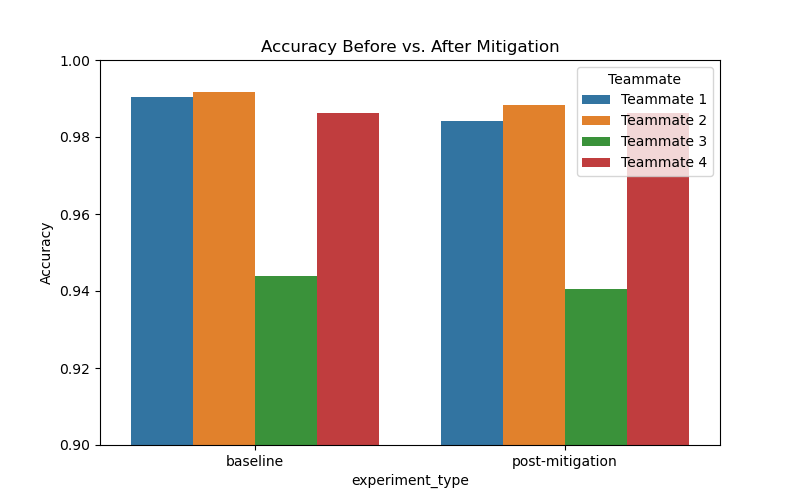

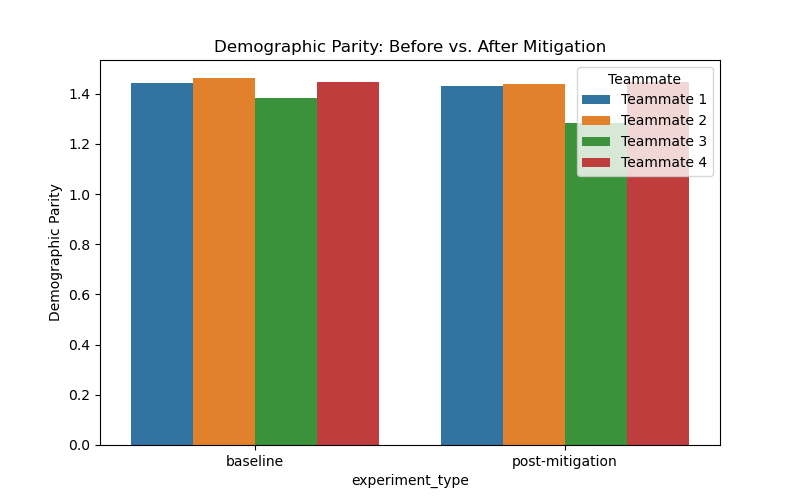

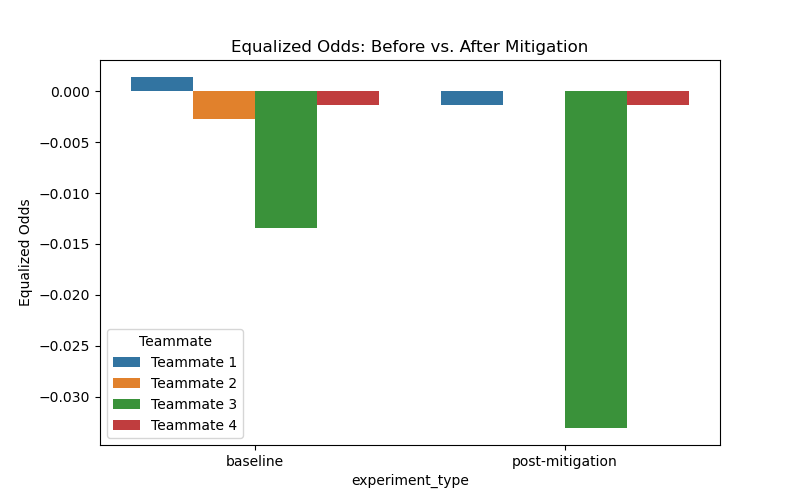

In [40]:
#Plot for Accuracy
plt.figure(figsize=(8, 5))
sns.barplot(x=overall_results["experiment_type"], y=overall_results["accuracy"], hue=overall_results["teammate"])
plt.title("Accuracy Before vs. After Mitigation")
plt.ylabel("Accuracy")
plt.ylim(0.9, 1.0)
plt.legend(title="Teammate")

plt.savefig("accuracy_plot.png")
plt.close()

# Display the image
from IPython.display import Image
Image("accuracy_plot.png")

#Plot for Demographic Parity
plt.figure(figsize=(8, 5))
sns.barplot(
    x=overall_results["experiment_type"],
    y=overall_results["demographic_parity"],
    hue=overall_results["teammate"]
)

plt.title("Demographic Parity: Before vs. After Mitigation")
plt.ylabel("Demographic Parity")
# Optionally adjust ylim depending on your data range
# plt.ylim(0.0, 2.0)
plt.legend(title="Teammate")

plt.savefig("demographic_parity_plot.png")
plt.close()

#Plot for Equalized Odds
plt.figure(figsize=(8, 5))
sns.barplot(
    x=overall_results["experiment_type"],
    y=overall_results["equalized_odds"],
    hue=overall_results["teammate"]
)

plt.title("Equalized Odds: Before vs. After Mitigation")
plt.ylabel("Equalized Odds")
# Adjust if you have small negative/positive values
# plt.ylim(-0.02, 0.03)
plt.legend(title="Teammate")

plt.savefig("equalized_odds_plot.png")
plt.close()

from IPython.display import Image
display(Image("accuracy_plot.png"))
display(Image("demographic_parity_plot.png"))
display(Image("equalized_odds_plot.png"))

The results show that Teammate 2's Prejudice Remover (in-processing) improved the most as Demographic Parity improved by 1.47% and Equalized Odds went to 0 from -0.0027, an improvement by 100%. This model was still able to keep a high accuaracy, dropping only slightly from 0.9917 to 0.9882. This suggests PrejudiceRemover gave the most balanced or noticeable improvement in fairness with minimal performance loss.Teammate 3's Disparate Impact Remover (Pre-Processing) reduced Demographic Parity from about 1.38 to 1.28, which is a larger decrease than Pejudice Remover. However, Equalized Odds got worse as the value got farther away from 0 by 126%, going from -0.0134 to -0.0303. This indicates a trade off that sacrificed Equaliozed odds for Demographic Parity. Teammate 1’s Equalized Odds (Post-processing) did achieve a small improvement as Demographic Parity went down from 1.4418 to 1.4308 and Teammate 4's Logistic Regression (Pre-Processing) had no effect.

Which Mitigation Strategy Resulted in the Most Improvement? 
- Teammate 2's Prejudice Remover (in-processing) showed the most improvement in fairness while maintaining performance.

Which Mitigation Strategy Resulted in the Least Improvement?
- Teammate 4's Logistic Regression (Pre-Processing) had no effect.

# References

[List the references you used to complete this milestone here.]
- Teammate 1: https://orangedatamining.com/blog/orange-fairness-equal-odds-postprocessing/
- Teammate 2: https://aif360.readthedocs.io/en/v0.4.0/modules/generated/aif360.algorithms.inprocessing.PrejudiceRemover.html
- Teammate 3: https://aif360.readthedocs.io/en/latest/modules/generated/aif360.algorithms.preprocessing.DisparateImpactRemover.html
- Teammate 4:

# Disclosures

[Disclose use of generative AI and similar tools here.]
- Teammate 1:
- Teammate 2:
- Teammate 3:
- Teammate 4: